In [26]:
%load_ext autoreload
%autoreload 2

import argparse
import os
from pathlib import Path

import numpy as np
import pandas as pd
import src.BertClassifier as BertClassifier
import src.utils as utils
import torch
import yaml
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

import wandb

device = utils.get_device()
config_path = "loo/classifier.yaml"
epochs = 10
num_training_examples = 1000

with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({"epochs": epochs, "num_training_examples": num_training_examples})

# Create datasets
train_dataset = create_train_sst2(
    device,
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
)

test_dataset = create_test_sst2(
    device,
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10658.47it/s]


## Train Model on Full Data

In [11]:
def train_model(train_dataset, test_dataset, config):
    train_dataloader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True
    )

    # Create classifcation model
    full_model = BertClassifier.create_bert_classifier(
        config["bert_model_name"],
        classifier_type=config["classifier_type"],
        classifier_hidden_size=config["classifier_hidden_size"],
        classifier_drop_out=config["classifier_drop_out"],
        freeze_bert=True,
        # random_state=42,
    )
    full_model.classifier.load_state_dict(
        torch.load("loo_10k/run_0/init_classifier_params.pt")
    )
    # torch.save(model.classifier.state_dict(), 'classifier_params.pt')

    optimizer = Adam(full_model.classifier.parameters(), lr=config["learning_rate"])
    loss_fn = torch.nn.CrossEntropyLoss()

    run = wandb.init(project="LOO-test", tags=["full"], config=config)

    timings = utils.train(
        config=config,
        model=full_model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        train_dataloader=train_dataloader,
        val_dataloader=None,
    )

    fdf, test_loss, test_acc = utils.evaluate_loss_df(full_model, test_dataloader)
    wandb.summary["test/loss"] = test_loss
    wandb.summary["test/accuracy"] = test_acc
    wandb.finish()

    return full_model, fdf, test_loss, test_acc

In [12]:
full_model, fdf, full_test_loss, full_test_acc = train_model(
    train_dataset, test_dataset, config
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: patcao. Use `wandb login --relogin` to force relogin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.19batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▇▇▇▇████
train/batch_loss,█▇▇▇▆▆▅▅▄▅▆▃▄▂▂▆▆▆▅▄▂▃▅▃▄▄▅▃▂▃▃▅▄▄▂▄▂▂▃▁
train/loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test/accuracy,81.76606
test/loss,0.4104
train/accuracy,87.79762
train/batch_loss,0.08084
train/loss,0.32155


## Train LOO Models

In [65]:
def train_loo_models(full_train_dataset, test_dataset, start_guid, end_guid, config):
    loo_losses = []

    for loo_guid in range(start_guid, end_guid):
        loo_dataset = create_loo_dataset(full_train_dataset, loo_guid)
        loo_model, ldf, full_test_loss, full_test_acc = train_model(
            loo_dataset, test_dataset, config
        )
        ldf['loo_guid'] = loo_guid
        loo_losses.append(ldf)
    ldf = pd.concat(loo_losses, axis=0)
    return ldf


In [66]:
%env WANDB_SILENT=true

ldf1 = train_loo_models(train_dataset, test_dataset, 0, 5, config)
ldf2 = train_loo_models(train_dataset, test_dataset, 0, 5, config)
# ldf3 = train_loo_models(train_dataset, test_dataset, 0, 5, config)

env: WANDB_SILENT=true


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.22batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇▇███
train/batch_loss,█▇█▆▅▄▄▄▆▃▆▃▅▂▃▇▃▇▇▄▂▃▄▅▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.42202
test/loss,0.41253
train/accuracy,86.90476
train/batch_loss,0.05864
train/loss,0.31616


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.45batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇████
train/batch_loss,█▇█▆▅▄▄▄▆▃▆▃▅▂▃▇▃▇▇▄▂▃▄▅▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.19266
test/loss,0.41348
train/accuracy,87.00397
train/batch_loss,0.05857
train/loss,0.31641


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.09batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇████
train/batch_loss,█▇█▆▅▄▄▄▆▃▆▃▅▂▃▇▃▇▇▄▂▃▄▅▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.19266
test/loss,0.41344
train/accuracy,87.00397
train/batch_loss,0.05868
train/loss,0.31629


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.82batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇▇▇████
train/batch_loss,█▇█▆▅▄▄▃▆▃▆▃▅▂▃▇▂▇█▄▂▃▄▄▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.30734
test/loss,0.41192
train/accuracy,87.30159
train/batch_loss,0.05965
train/loss,0.31542


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.90batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇████
train/batch_loss,█▇█▆▅▄▄▃▆▃▆▃▅▂▃▇▂▇█▄▂▃▄▄▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.5367
test/loss,0.41234
train/accuracy,87.20238
train/batch_loss,0.05917
train/loss,0.3163


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.92batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇▇███
train/batch_loss,█▇█▆▅▄▄▄▆▃▆▃▅▂▃▇▃▇▇▄▂▃▄▅▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.42202
test/loss,0.41253
train/accuracy,86.90476
train/batch_loss,0.05864
train/loss,0.31616


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.05batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇████
train/batch_loss,█▇█▆▅▄▄▄▆▃▆▃▅▂▃▇▃▇▇▄▂▃▄▅▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.19266
test/loss,0.41348
train/accuracy,87.00397
train/batch_loss,0.05857
train/loss,0.31641


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.13batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇████
train/batch_loss,█▇█▆▅▄▄▄▆▃▆▃▅▂▃▇▃▇▇▄▂▃▄▅▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.19266
test/loss,0.41344
train/accuracy,87.00397
train/batch_loss,0.05868
train/loss,0.31629


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.48batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇▇▇████
train/batch_loss,█▇█▆▅▄▄▃▆▃▆▃▅▂▃▇▂▇█▄▂▃▄▄▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.30734
test/loss,0.41192
train/accuracy,87.30159
train/batch_loss,0.05965
train/loss,0.31542


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00, 10.43batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇████
train/batch_loss,█▇█▆▅▄▄▃▆▃▆▃▅▂▃▇▂▇█▄▂▃▄▄▄▃▃▂▃▃▄▅▂▁▃▃▂▁▄▃
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,81.5367
test/loss,0.41234
train/accuracy,87.20238
train/batch_loss,0.05917
train/loss,0.3163


In [72]:
m = pd.merge(ldf1, ldf2, on=['loo_guid', 'test_guid', 'label'], how='outer', suffixes=('_1', '_2'))

In [70]:
TEST_GUID = 672

print(fdf[fdf.test_guid == TEST_GUID].loss.squeeze())
cdf1 = ldf1[ldf1.test_guid == TEST_GUID].copy()
cdf1

1.4237847328186035


,test_guid,logits,pred,label,loss,loo_guid
672,672,"[-0.5507879, 0.35016587]",1,0,1.241832,0
672,672,"[-0.56930864, 0.36868525]",1,0,1.268313,1
672,672,"[-0.5737928, 0.37316567]",1,0,1.274764,2
672,672,"[-0.5680335, 0.36740777]",1,0,1.266479,3
672,672,"[-0.5688917, 0.36826742]",1,0,1.267713,4


In [71]:
cdf2 = ldf2[ldf2.test_guid == TEST_GUID].copy()
cdf2

,test_guid,logits,pred,label,loss,loo_guid
672,672,"[-0.5507879, 0.35016587]",1,0,1.241832,0
672,672,"[-0.56930864, 0.36868525]",1,0,1.268313,1
672,672,"[-0.5737928, 0.37316567]",1,0,1.274764,2
672,672,"[-0.5680335, 0.36740777]",1,0,1.266479,3
672,672,"[-0.5688917, 0.36826742]",1,0,1.267713,4


## Compute Loss Influence

In [57]:
import src.influence as inf_utils

param_infl = list(full_model.classifier.parameters())
infl = inf_utils.compute_influence(
    full_model=full_model,
    test_guid=TEST_GUID,
    param_influence=param_infl,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    lissa_r=2,
    lissa_depth=1,
    damping=5e-3,
    scale=100,
    # training_indices=list(range(15)),
)

LiSSA reps: 2 and num_iterations: 1000
Recursion at depth 0: norm is 22.552303
Recursion at depth 200: norm is 384.422791
Recursion at depth 400: norm is 500.881500
Recursion at depth 600: norm is 541.121216
Recursion at depth 800: norm is 552.174866
Recursion at depth 999: norm is 553.671875
Recursion at depth 0: norm is 22.804285
Recursion at depth 200: norm is 385.242523
Recursion at depth 400: norm is 499.265137
Recursion at depth 600: norm is 537.080750
Recursion at depth 800: norm is 552.299744
Recursion at depth 999: norm is 557.240051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.15it/s]


## Compare Influence with LOO

In [58]:
cdf["loss_diff"] = fdf[fdf.test_guid == TEST_GUID].loss.squeeze() - cdf["loss"]
cdf["if_diff"] = (-100.0 / len(train_dataset)) * infl[: len(cdf)]
cdf

,test_guid,logits,pred,label,loss,loo_guid,loss_diff,if_diff
672,672,"[-0.5507879, 0.35016587]",1,0,1.241832,0,0.181953,-0.023979
672,672,"[-0.56930864, 0.36868525]",1,0,1.268313,1,0.155472,-0.005492
672,672,"[-0.5737928, 0.37316567]",1,0,1.274764,2,0.149021,0.000964
672,672,"[-0.5680335, 0.36740777]",1,0,1.266479,3,0.157305,-0.065581
672,672,"[-0.5688917, 0.36826742]",1,0,1.267713,4,0.156071,-0.022410
672,672,"[-0.57793206, 0.37730497]",1,0,1.280736,5,0.143049,-0.083358
672,672,"[-0.56930715, 0.3686824]",1,0,1.268310,6,0.155475,0.367314
672,672,"[-0.5682944, 0.36767137]",1,0,1.266856,7,0.156929,0.028438
672,672,"[-0.5574658, 0.3568388]",1,0,1.251345,8,0.172440,0.005149
672,672,"[-0.58157384, 0.380947]",1,0,1.286001,9,0.137784,0.378818


In [59]:
cdf[['loss_diff', 'if_diff']].corr()

,loss_diff,if_diff
loss_diff,1.000000,-0.353463
if_diff,-0.353463,1.000000


<Axes: xlabel='loss_diff', ylabel='if_diff'>

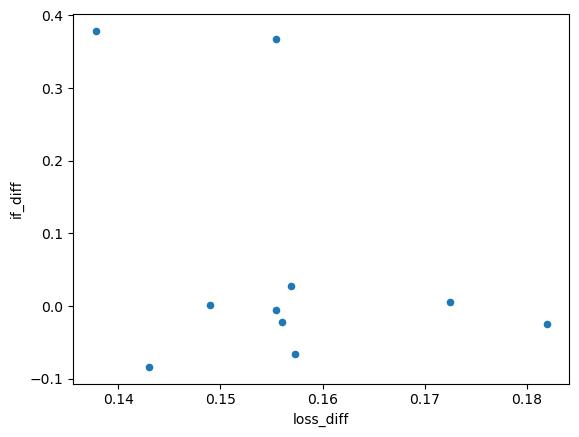

In [60]:
cdf[['loss_diff', 'if_diff']].plot.scatter('loss_diff', 'if_diff')

In [62]:
# median_idx = int(len(infl) / 2)

idxs = np.argsort(infl)[:10]

In [63]:
infl[idx]

NameError: name 'idx' is not defined

## Remove Random 10%

In [55]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

remove_idxs = np.random.randint(low=0, high=len(train_dataset), size=remove_length)
loo_dataset = create_loo_dataset(train_dataset, remove_idxs)

rand_model, rdf, rad_test_loss, rand_test_acc = train_model(
    loo_dataset, test_dataset, config
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 30.51batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▆▇██████
train/batch_loss,▇▇▇▆▅▄█▅▃▃▅▄▄▃▃▄▃▅▃▅▃▁▃▂▃▂▂▃▃▂▁▂▂▂▃▃▂▃▄▂
train/loss,█▅▃▃▂▁▂▁▁▁
epoch,10
test/accuracy,81.65138
test/loss,0.4005
train/accuracy,87.41228
train/batch_loss,0.22451
train/loss,0.31727


In [56]:
rdf[rdf.test_guid == TEST_GUID]

,test_guid,logits,pred,label,loss
218,218,"[-2.3591306, 1.9379474]",1,0,4.310595


## Remove Top 10% Influences

In [57]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(-infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

t_model, tdf, top_test_loss, top_test_acc = train_model(
    loo_dataset, test_dataset, config
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 31.46batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▇▇██████
train/batch_loss,█▇██▅▅▄▃▄▂▅▅▃▄▃▂▅▅▄▃▂▂▁▃▂▃▃▄▁▅▃▃▄▂▁▂▅▂▃▂
train/loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test/accuracy,77.1789
test/loss,0.51965
train/accuracy,90.57018
train/batch_loss,0.06399
train/loss,0.25092


In [58]:
tdf[tdf.test_guid == TEST_GUID]

,test_guid,logits,pred,label,loss
218,218,"[-3.8995392, 3.4783514]",1,0,7.378515


## Remove Bottom 10% Influences

In [59]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

b_model, bdf, bot_test_loss, bot_test_acc = train_model(
    loo_dataset, test_dataset, config
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 31.85batch/s]


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▇▇██████
train/batch_loss,▇██▆▄▅▆▄▄▅▂▄▃▂▂▃▂▂▁▃▂▃▂▂▃▃▄▂▁▄▃▂▂▂▂▁▃▂▁▂
train/loss,█▅▃▂▂▁▂▁▁▁
epoch,10
test/accuracy,80.50459
test/loss,0.49213
train/accuracy,92.43421
train/batch_loss,0.00738
train/loss,0.21154


In [60]:
fdf[fdf.test_guid == TEST_GUID]

,test_guid,logits,pred,label,loss
218,218,"[-2.6175587, 2.196372]",1,0,4.822014


In [61]:
rdf[rdf.test_guid == TEST_GUID]

,test_guid,logits,pred,label,loss
218,218,"[-2.3591306, 1.9379474]",1,0,4.310595


In [62]:
tdf[tdf.test_guid == TEST_GUID]

,test_guid,logits,pred,label,loss
218,218,"[-3.8995392, 3.4783514]",1,0,7.378515


In [63]:
bdf[bdf.test_guid == TEST_GUID]

,test_guid,logits,pred,label,loss
218,218,"[-1.9649189, 1.5437354]",1,0,3.538152


In [64]:
import src.datasets as datasets

datasets.get_test_example(TEST_GUID).sentence.squeeze()

"all that 's missing is the spontaneity , originality and delight . "

In [65]:
fdf.sort_values("loss", ascending=False)

,test_guid,logits,pred,label,loss
862,862,"[-2.6032255, 2.5181246]",1,0,5.127301
218,218,"[-2.6175587, 2.196372]",1,0,4.822014
528,528,"[1.7552543, -2.128434]",0,1,3.904054
292,292,"[-1.9731425, 1.7984262]",1,0,3.794324
494,494,"[-1.9141355, 1.6650913]",1,0,3.606742
...,...,...,...,...,...
837,837,"[-4.07821, 3.9298441]",1,1,0.000333
502,502,"[4.060814, -3.968587]",0,0,0.000326
457,457,"[-4.258335, 4.074312]",1,1,0.000241
443,443,"[-4.2041993, 4.1626873]",1,1,0.000232


In [66]:
---stop---

SyntaxError: invalid syntax (2563437544.py, line 1)

## Compare IF and LOO

In [ ]:
fdf[fdf.test_guid == test_guid].loss.squeeze()

In [ ]:
# Load Losses from File
# ldf = pd.read_csv("loo_10k/all_loo_losses.csv")
ldf = pd.concat(loo_dfs, axis=0)

ldf = ldf[ldf.test_guid == test_guid]
ldf["loss_diff"] = ldf["loss"] - fdf[fdf.test_guid == test_guid].loss.squeeze()
ldf["if_diff"] = (-100.0 / len(train_dataset)) * infl[: len(ldf)]
ldf["if_diff2"] = (-1000.0 / len(train_dataset)) * influences[: len(ldf)]
ldf

In [ ]:
print(ldf[["loss_diff", "if_diff", "if_diff2"]].corr())
ldf[["loss_diff", "if_diff"]]

In [ ]:
ldf[["loss_diff", "if_diff"]].plot.scatter("loss_diff", "if_diff")

## Compute Input Influence

In [ ]:
# import src.influence as inf_utils

# test_guid = 560
# param_infl = list(full_model.classifier.parameters())
# infl = inf_utils.compute_input_influence(
#     full_model=full_model,
#     test_guid=test_guid,
#     param_influence=param_infl,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     lissa_r=1,
#     lissa_depth=0.1,
#     damping=5e-3,
#     scale=100,
#     training_indices=[0],
# )

## Torch Influence

In [ ]:
import copy

from src.torch_influence import BaseObjective
from src.torch_influence.modules import CGInfluenceModule, LiSSAInfluenceModule


class BinClassObjective(BaseObjective):
    def train_outputs(self, model, batch):
        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        return model(b_input_ids, b_attn_mask)

    def train_loss_on_outputs(self, outputs, batch):
        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        loss_fn = torch.nn.CrossEntropyLoss()
        return loss_fn(outputs, b_labels)

    def train_regularization(self, params):
        return 0

    def test_loss(self, model, params, batch):
        loss_fn = torch.nn.CrossEntropyLoss()

        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        outputs = model(b_input_ids, b_attn_mask)

        return loss_fn(outputs, b_labels)


infl_model = BertClassifier.create_bert_classifier(
    config["bert_model_name"],
    classifier_type=config["classifier_type"],
    classifier_hidden_size=config["classifier_hidden_size"],
    classifier_drop_out=config["classifier_drop_out"],
    freeze_bert=True,
    random_state=42,
)
infl_model.load_state_dict(copy.deepcopy(full_model.state_dict()))

module = LiSSAInfluenceModule(
    model=infl_model,
    objective=BinClassObjective(),
    train_loader=DataLoader(train_dataset, batch_size=32),
    test_loader=DataLoader(test_dataset, batch_size=32),
    device=utils.get_device(),
    damp=0.001,
    repeat=1,
    depth=50,
    scale=1e4,
)

all_train_idxs = list(range(len(train_dataset)))
influences = module.influences(all_train_idxs, [test_guid])

In [ ]:
influences[:10]